In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [2]:
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_prod_0_consolidated.parquet"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [22]:
session_table.to_pandas().query('session_id == "664851_2023-11-13"')['n_passing_blocks']

78    5.0
Name: n_passing_blocks, dtype: float64

In [4]:
results=pl.scan_parquet(results_path)

In [5]:
results.columns

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20096\2894113179.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  results.columns


['balanced_accuracy_test',
 'time_aligned_to',
 'bin_size',
 'bin_center',
 'shift_idx',
 'repeat_idx',
 'predict_proba',
 'unit_ids',
 'is_all_trials',
 'session_id',
 'structure',
 'electrode_group_names',
 'unit_subsample_size',
 'unit_criteria']

In [6]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [7]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = True
if keep_original_structure:
    n_repeats = 2

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modal_dprime_vis_blocks',
            'cross_modal_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
                               'cross_modal_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
                                                           'cross_modal_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
        pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    )
    .sort('structure', 'unit_subsample_size', descending=False)
    .collect()
)


In [8]:
new_results_session_df

cross_modal_dprime_vis_blocks,time_aligned_to,bin_size,n_passing_blocks,session_id,unit_subsample_size,cross_modal_dprime_aud_blocks,bin_center,total_n_units,structure,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
str,enum,f64,i64,str,u16,str,f64,u32,str,f64,f64,list[f64],list[i16],f64
"""1.1929835410732137;2.390691283…","""stim_start_time""",0.2,6,"""668755_2023-08-31""",20,"""1.4565226919873606;1.889509960…",-0.3,83,"""ACAd""",0.774447,0.627852,"[0.558029, 0.563327, … 0.557198]","[-43, -42, … 45]",0.146595
"""-0.022032473687224385;0.022032…","""stim_start_time""",0.2,0,"""676909_2023-12-12""",20,"""0.0;-0.04842155051939967;0.0""",0.9,135,"""ACAd""",0.529849,0.536345,"[0.53697, 0.543865, … 0.567742]","[-45, -44, … 42]",-0.006496
"""3.5827851378043025;2.853990868…","""response_time""",0.2,6,"""674562_2023-10-03""",20,"""3.4792322964173557;3.875863021…",-0.3,82,"""ACAd""",0.828142,0.595663,"[0.627335, 0.586036, … 0.574314]","[-20, -19, … 12]",0.23248
"""2.7645603649003543;2.996397374…","""response_time""",0.2,5,"""742903_2024-10-22""",20,"""3.5077246430786078;2.296002124…",1.5,134,"""ACAd""",0.575187,0.559179,"[0.583615, 0.586207, … 0.553705]","[-14, -13, … 9]",0.016007
"""1.9151915663243013;1.619856258…","""stim_start_time""",0.2,4,"""726088_2024-06-21""",20,"""0.6784124189954537;0.692095767…",0.5,64,"""ACAd""",0.597354,0.551149,"[0.526772, 0.51992, … 0.532908]","[-46, -45, … 45]",0.046205
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""3.0833722162690016;2.791631359…","""response_time""",0.2,5,"""662892_2023-08-23""",20,"""0.29293181590561934;2.64489216…",0.7,173,"""root""",0.53634,0.52834,"[0.522915, 0.518487, … 0.515749]","[-19, -18, … 24]",0.008
"""3.0833722162690016;2.791631359…","""response_time""",0.2,5,"""662892_2023-08-23""",20,"""0.29293181590561934;2.64489216…",0.1,173,"""root""",0.524642,0.514131,"[0.544392, 0.532807, … 0.507339]","[-19, -18, … 24]",0.010512
"""3.0833722162690016;2.791631359…","""response_time""",0.2,5,"""662892_2023-08-23""",20,"""0.29293181590561934;2.64489216…",1.1,173,"""root""",0.552157,0.52787,"[0.490044, 0.496143, … 0.515034]","[-19, -18, … 24]",0.024287


In [9]:
new_results_session_pd=new_results_session_df.to_pandas()

In [10]:
new_results_session_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_prod_0_2025-05-02\decoder_accuracy_by_session.parquet", index=False)

In [11]:
new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
                             time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

,cross_modal_dprime_vis_blocks,time_aligned_to,bin_size,n_passing_blocks,session_id,unit_subsample_size,cross_modal_dprime_aud_blocks,bin_center,total_n_units,structure,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
901,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,-0.3,135,ACAd,0.681012,0.578063,"[0.5150089734554851, 0.5217118628141884, 0.526...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.102950
377,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,-0.1,135,ACAd,0.685923,0.589955,"[0.5492034766267325, 0.5510556260277188, 0.553...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.095968
602,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,0.1,135,ACAd,0.645649,0.564244,"[0.5366436457599248, 0.5289527366690158, 0.533...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.081405
498,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,0.3,135,ACAd,0.633106,0.567052,"[0.5315930937279777, 0.5379514681700729, 0.538...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.066054
356,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,0.5,135,ACAd,0.641791,0.558653,"[0.5400965938454312, 0.5350165374677003, 0.535...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.083138
976,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,0.7,135,ACAd,0.612384,0.551117,"[0.5242553911205075, 0.523714352830632, 0.5186...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.061267
355,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,0.9,135,ACAd,0.622130,0.559382,"[0.5259411322527603, 0.5301330044632371, 0.520...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.062748
449,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,1.1,135,ACAd,0.629471,0.576847,"[0.5549012919896641, 0.557706225041109, 0.5564...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.052624
808,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,1.3,135,ACAd,0.628367,0.558770,"[0.5343073995771671, 0.5272753112520555, 0.529...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.069597
89,3.5577877694910995;-0.048778354035492744;3.196...,stim_start_time,0.2,5,664851_2023-11-13,20,3.852437335908387;2.053711660354647;2.70264118...,1.5,135,ACAd,0.628747,0.561207,"[0.5265714352830632, 0.5324430350011745, 0.531...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.067540


Text(0.5, 1.0, '664851_2023-11-13; SCm; stim_start_time; 20 units')

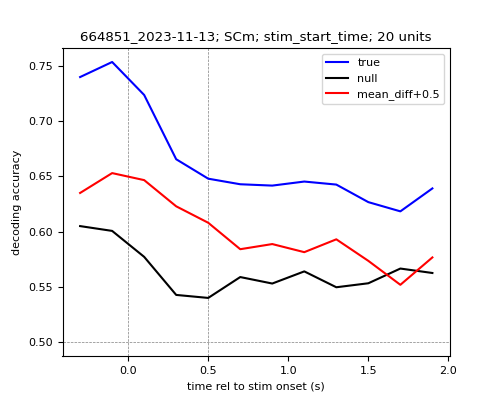

In [163]:
sel_session="664851_2023-11-13"
sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')
example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                     time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label='true', color='blue')
ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['median_null'], label='null', color='black')

ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_diff']+0.5, label='mean_diff+0.5', color='red')

# ax.set_ylim(0.5,1)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [13]:

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = True
if keep_original_structure:
    n_repeats = 2

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_context', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_context', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [14]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [15]:
predict_proba_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_prod_0_2025-05-02\predict_proba_by_session.parquet", index=False)

In [60]:
predict_proba_pd

,session_id,structure,unit_subsample_size,bin_center,time_aligned_to,balanced_accuracy_test,total_n_units,predict_proba,trial_index,is_vis_context,stim_name,is_response
0,620263_2022-07-26,ACAv,20,-0.3,response_time,0.561013,277,"[0.4910773213834776, 0.5200024369344334, 0.514...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr..."
1,620263_2022-07-26,ACAv,20,-0.3,stim_start_time,0.555207,277,"[0.4645820897031065, 0.46317788187065595, 0.59...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr..."
2,620263_2022-07-26,ACAv,20,-0.1,response_time,0.524679,277,"[0.49657072921340517, 0.563540921953941, 0.467...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr..."
3,620263_2022-07-26,ACAv,20,-0.1,stim_start_time,0.573977,277,"[0.5380389679150731, 0.5854726742238422, 0.611...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr..."
4,620263_2022-07-26,ACAv,20,0.1,stim_start_time,0.578986,277,"[0.5840713922368457, 0.5493444375370441, 0.568...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr..."
...,...,...,...,...,...,...,...,...,...,...,...,...
46987,761583_2024-12-17,VPM,20,1.5,response_time,0.513576,222,"[0.45968832190546294, 0.42283888989282103, 0.5...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr..."
46988,761583_2024-12-17,VPM,20,1.7,response_time,0.511643,222,"[0.4184976764734595, 0.5141117200241516, 0.525...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr..."
46989,761583_2024-12-17,VPM,20,1.7,stim_start_time,0.511599,222,"[0.40769634963059637, 0.4349191969036944, 0.36...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr..."
46990,761583_2024-12-17,VPM,20,1.9,stim_start_time,0.527788,222,"[0.5148647006887072, 0.527890674293996, 0.4402...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr..."


In [130]:
sel_session="664851_2023-11-13"
sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"

###hack used until we add trial_index to the results
if sel_time_aligned_to=='response_time':
    temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                            time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                            ).sort_values('bin_center').iloc[0]
    
    trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
    is_vis_context=temp_trial_info['is_vis_context'][temp_trial_info['is_response']]
    stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
    is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)
    trial_index_list=[]
    is_vis_context_list=[]
    stim_name_list=[]
    is_response_list=[]
    for rr in range(len(example_area_results)):
        trial_index_list.append(trial_index)
        is_vis_context_list.append(is_vis_context)
        stim_name_list.append(stim_name)
        is_response_list.append(is_response)

    example_area_results['trial_index']=trial_index_list
    example_area_results['is_vis_context']=is_vis_context_list
    example_area_results['stim_name']=stim_name_list
    example_area_results['is_response']=is_response_list

else:
    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)

np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0]

array([ 84, 169, 262, 350, 438], dtype=int64)

In [90]:
# example_area_results.loc[rr,'trial_index']
# trial_index

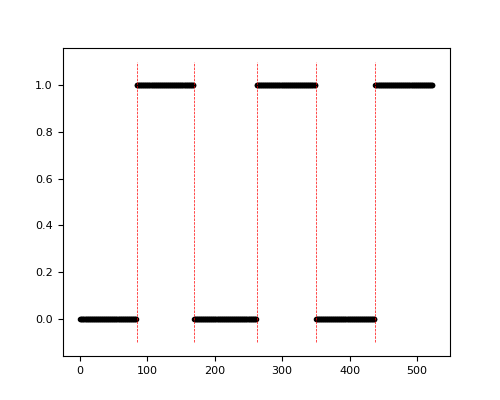

In [131]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.plot(example_area_results['is_vis_context'].iloc[0],'k.')
ax.vlines(x=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0],ymin=-.1,ymax=1.1, color='red', linestyle='--', linewidth=0.5)

Text(0.5, 1.0, '664851_2023-11-13; SCm; response_time; 20 units; \n              trial 83; sound1; is_vis_context=False')

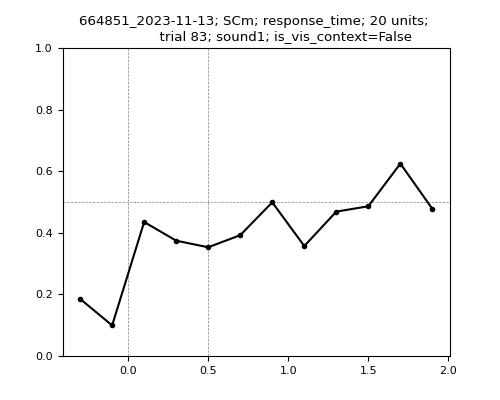

In [162]:
sel_trial=83
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(example_area_results['bin_center'],np.vstack(example_area_results['predict_proba'].values)[:,sel_trial], 'k.-')
ax.set_ylim(0,1)

ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units; \n \
             trial {example_area_results['trial_index'].iloc[0][sel_trial]}; {example_area_results['stim_name'].iloc[0][sel_trial]}; is_vis_context={example_area_results['is_vis_context'].iloc[0][sel_trial]}")

In [ ]:
# aggregate predict proba in a smart way over trials & structures


# switches (contingent, non-contingent) + pre,post block dprime + trials_since_switch


# rewards (lick & get reward) + block dprime + is_instruction_trial


# reward prediction errors (lick & get no reward, no lick & get reward?) + block dprime + is_instruction_trial


# average non target, non response



In [155]:
# is_vis_context

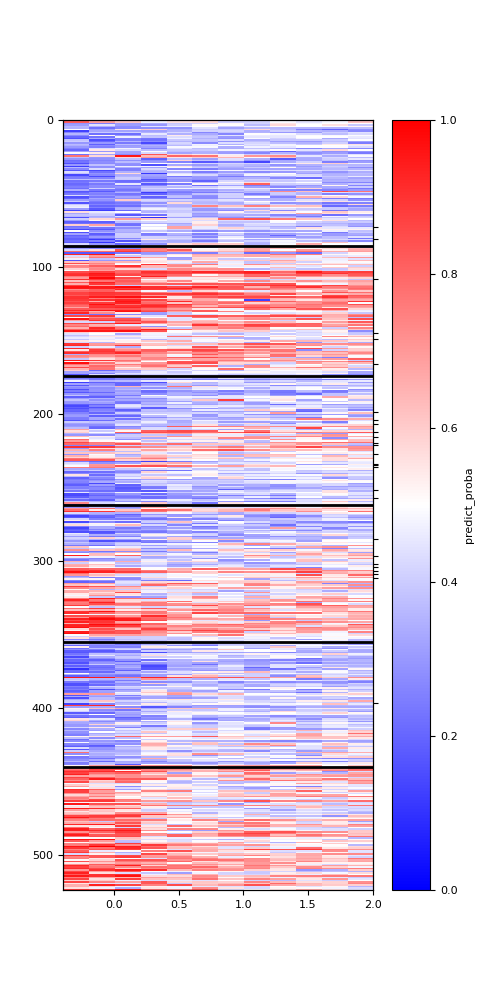

In [159]:
predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

fig,ax=plt.subplots(1,1,figsize=(5,10))
im=ax.imshow(predict_proba_stack, aspect='auto', interpolation='none', extent=[-0.4, 2.0, predict_proba_stack.shape[0],0], cmap='bwr', vmin=0, vmax=1)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('predict_proba')

#make tickmarks on right side for false alarms
is_vis_context=example_area_results['is_vis_context'].values[0]
stim_name=example_area_results['stim_name'].values[0]
is_response=example_area_results['is_response'].values[0]

is_false_alarm=(
    is_vis_context & (stim_name == 'sound1') & (is_response == True) |
    ~is_vis_context & (stim_name == 'vis1') & (is_response == True)
)

ax2=ax.twinx()
ax2.set_ylim(0, predict_proba_stack.shape[0])
ax2.set_yticks(np.where(is_false_alarm)[0])
ax2.set_yticklabels([])

#plot context switch lines
context_switches=len(is_vis_context)-np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0]
for rr in range(len(context_switches)):
    ax.axhline(y=context_switches[rr], color='k', linestyle='-', linewidth=2.0)